# ALEXNET CNN

## Setup

In [1]:
import os
import sys
import numpy as np
from pathlib import Path

In [2]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: Using Google CoLab")
except:
    print("Note: Not using Google CoLab")
    COLAB = False

if COLAB:
    if not os.path.ismount("/content/drive"):
        print("Note: Mounting drive")
        drive.mount('/content/drive')
    else:
        print("Note: Drive already mounted")

    os.system("pip install pycm")
    print("Note: pycm installed")

    sys.path.append("/content/drive/MyDrive/tumorclass.info")
    sys.path.append("/content/drive/MyDrive/tumorclass.info/notebooks")

    PROJECT_PATH = "/content/drive/MyDrive/tumorclass.info"

else:
    PROJECT_PATH = str(Path.cwd().parent)

DATA_PATH = os.path.join(PROJECT_PATH, "data/")
MODELS_PATH = os.path.join(PROJECT_PATH, "models/")
DATASET_PATH = os.path.join(PROJECT_PATH, "data/dataset/")
SRC_0_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_0/")
SRC_1_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_1/")
SRC_2_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_2/")
TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/")
TRAIN_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/normal/")
TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/lgg/")
TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/hgg/")
TEST_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/")
TEST_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/normal/")
TEST_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/lgg/")
TEST_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/hgg/")
VALID_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/")
VALID_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/normal/")
VALID_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/lgg/")
VALID_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/hgg/")
AUG_TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/")
AUG_TRAIN_NORMAL_PATH = os.path.join(
    PROJECT_PATH, "data/dataset/aug_train/normal/"
)
AUG_TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/lgg/")
AUG_TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/hgg/")

try:
    TEST_NORMAL_FILES = np.array(sorted(os.listdir(TEST_NORMAL_PATH)))
    TEST_LGG_FILES = np.array(sorted(os.listdir(TEST_LGG_PATH)))
    TEST_HGG_FILES = np.array(sorted(os.listdir(TEST_HGG_PATH)))
except FileNotFoundError:
    print("Note: No test data found! Run preprocessing.ipynb first.")

Note: Using Google CoLab
Note: Mounting drive
Mounted at /content/drive
Note: pycm installed


In [15]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import (
    Dense,
    Input,
    BatchNormalization,
    Conv2D,
    Dropout,
    Flatten,
    MaxPooling2D,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tools.data import (
    learning_rate_scheduler,
    confusion_matrix,
    count_params,
    predict_gen,
    predictor,
    enumerate_oxford,
    compare_predictions,
    p_join
)
from tools.file import mkdir_if_not_exists, pickler
from tools.visualize import plot_batch, plot_epochs

In [4]:
MODEL_NAME = "cnn_alexnet"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_MODE = "rgb" # "grayscale"
IMAGE_CHANNELS = 3  # 1
CLASSES = ["normal", "lgg", "hgg"]
CLASS_MODE = "categorical"
SEED = 42

BATCH_SIZE = 24

## Prepare data

In [9]:
augment = True

train_gen = ImageDataGenerator(
    rescale=1.0 / 255,
).flow_from_directory(
    directory=(AUG_TRAIN_PATH if augment else TRAIN_PATH),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="training",
    shuffle=True,
    seed=SEED,
)

valid_gen = ImageDataGenerator(
    rescale=1.0 / 255,
).flow_from_directory(
    directory=VALID_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="validation",
    shuffle=True,
    seed=SEED,
)

test_gen = ImageDataGenerator(
    rescale=1.0 / 255,
).flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False,
    seed=SEED,
)

Found 1045 images belonging to 3 classes.
Found 204 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [10]:
assert train_gen.n == 1045 if augment else train_gen.n == 471
assert valid_gen.n == 204
assert test_gen.n == 60
assert (
    train_gen.num_classes
    == test_gen.num_classes
    == valid_gen.num_classes
    == 3
)

In [11]:
images, labels = next(train_gen)

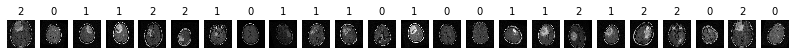

In [12]:
plot_batch(images, labels, argmax=True)

## Build Fine-tuned ALEXNET model

In [16]:
model = Sequential()

# the 2 first values in in input shape is the width and height of the image, the last is the color channel.
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)  # X_train.shape[1:]  # <-- Not hidden, not counted

# ### Conv2D ###
# filters is the number of filters that is learning.
# The kernel_size is the filter/matrix size
# The stride is the actual convolving.
# padding = "same" keeps the origional dimensionality

model.add(
    Conv2D(
        filters=96,
        kernel_size=(11, 11),
        padding="same",
        strides=(4, 4),
        activation="relu",
        input_shape=input_shape,
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(
    Conv2D(
        filters=256,
        kernel_size=(5, 5),
        padding="same",
        strides=(1,1),
        activation="relu",
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(
    Conv2D(
        filters=384,
        kernel_size=(3, 3),
        padding="same",
        strides=(1,1),
        activation="relu",
    )
)
model.add(BatchNormalization())

model.add(
    Conv2D(
        filters=384,
        kernel_size=(3, 3),
        padding="same",
        strides=(1,1),
        activation="relu",
    )
)
model.add(BatchNormalization())

model.add(
    Conv2D(
        filters=256,
        kernel_size=(3, 3),
        padding="same",
        strides=(1,1),
        activation="relu",
    )
)
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# First dense layer in model has to have a flatten
model.add(Flatten())

model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.5))

# ! Dropout should not be added to last hidden layer. Still is in Alexnet.
# model.add(Dense(256, activation="relu"))

### Will give same result ###
## Binary only
# When using loss="binary_crossentropy"
# model.add(Dense(1, activation="sigmoid"))

## Can also be used when more than two classes
# When using loss="categorical_crossentropy"
model.add(Dense(3, activation="softmax"))

In [17]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

conv2d
batch_normalization
max_pooling2d
conv2d_1
batch_normalization_1
max_pooling2d_1
conv2d_2
batch_normalization_2
conv2d_3
batch_normalization_3
conv2d_4
batch_normalization_4
max_pooling2d_2
flatten
dense
dropout
dense_1
dropout_1
dense_2


In [18]:
model.summary()
params = count_params(model)
# print(f"Trainable params: {params['trainable_params']:,}")
# print(f"Non-trainable params: {params['non_trainable_params']:,}")
# assert params['trainable_params'] == 1_053_699
# assert params['non_trainable_params'] == 2_178_240

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 56, 56, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

## Compile model

In [19]:
model.compile(
    optimizer=Adam(
        learning_rate=0.001,  # (0.001 * np.sqrt(0.1)),
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False,
        name="Adam",
    ),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Fit model

In [20]:
epochs = 30

set_callbacks = [
    # "lr_schedule",
    "lr_plateau",
    "early_stopping",
    "model_checkpoint",
]

if "lr_schedule" in set_callbacks and "lr_plateau" in set_callbacks:
    set_callbacks.pop(set_callbacks.index("lr_plateau"))
    print("Note: 'LearningRateScheduler' always wins over 'ReduceLROnPlateau'\n")

callbacks = []
callback_names = []

if set_callbacks:
    if "lr_schedule" in set_callbacks:
        learning_rate_schedule = learning_rate_scheduler(
            # epoch_steps=[5, 20],  # None,
            initial_lr=round(float(model.optimizer.learning_rate.numpy()), 8),
            # lr_steps=[0.1, 0.1],  # None,
            # use_factor=True,
            verbose=1
        )
        lr_schedule = LearningRateScheduler(learning_rate_schedule)
        model.optimizer.learning_rate = learning_rate_schedule(0)
        print(
            "[LR SCHEDULE]:\n"
            f"\tEpoch_steps: {getattr(learning_rate_schedule, 'epoch_steps')}\n"
            f"\tInitial_lr: {getattr(learning_rate_schedule, 'initial_lr')}\n"
            f"\tLr_steps: {getattr(learning_rate_schedule, 'lr_steps')}\n"
            f"\tUse_factor: {getattr(learning_rate_schedule, 'use_factor')}\n"
            )
        if getattr(learning_rate_schedule, 'use_factor'):
            epcs = getattr(learning_rate_schedule, 'epoch_steps')
            curr_step = round(float(model.optimizer.learning_rate.numpy()), 8)
            print(str(f"\tEpoch 0: {curr_step:.10f}").rstrip("0"))
            for i, step in enumerate(getattr(learning_rate_schedule, 'lr_steps')):
                curr_step *= step
                print(str(f"\tEpoch {epcs[i]}: {curr_step:.10f}").rstrip("0"))
            print()

        callbacks.append(lr_schedule)
        callback_names.append("lr_schedule")

    if "lr_plateau" in set_callbacks:
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            factor=np.sqrt(0.1),
            patience=2,
            verbose=1,
            mode="auto",
            # min_delta=0.01,
            cooldown=0,
            min_lr=0.5e-6,
        )
        callbacks.append(lr_plateau)
        callback_names.append("lr_plateau")

    if "early_stopping" in set_callbacks:
        early_stopping = EarlyStopping(
            monitor="val_loss",
            # min_delta=0.01,
            patience=6,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
        callback_names.append("early_stopping")

    if "model_checkpoint" in set_callbacks:
        model_checkpoint = ModelCheckpoint(
            filepath=p_join(MODELS_PATH, MODEL_NAME + "_" + "checkpoint.hdf5"),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            options=None,
        )
        callbacks.append(model_checkpoint)
        callback_names.append("model_checkpoint")

print(f"Selected callbacks: {enumerate_oxford(callback_names)}")

Selected callbacks: lr_plateau, early_stopping, and model_checkpoint


In [21]:
TRAIN_STEPS_PER_EPOCH = int(train_gen.n / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = int(valid_gen.n / BATCH_SIZE)
print("Train steps per epoch:", TRAIN_STEPS_PER_EPOCH)
print("Valid steps per epoch:", VALID_STEPS_PER_EPOCH)

Train steps per epoch: 43
Valid steps per epoch: 8


In [22]:
model_operation = "fit"

mkdir_if_not_exists(MODELS_PATH)

clear_session()

if model_operation == "fit":
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        validation_data=valid_gen,
        validation_steps=VALID_STEPS_PER_EPOCH,
        verbose=2,
        callbacks=callbacks if len(callbacks) > 0 else None,
        # workers=2,
    )

    save_model(model, os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))

    # save model history
    pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"),
        "save",
        history,
    )

elif model_operation == "load":
    model = load_model(os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))
    history = pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"), "load"
    )

elif model_operation == "checkpoint":
    model = load_model(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_checkpoint.hdf5")
    )
    history = None

Epoch 1/30

Epoch 1: val_loss improved from inf to 800.10718, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_alexnet_checkpoint.hdf5
43/43 - 574s - loss: 17.3928 - accuracy: 0.5544 - val_loss: 800.1072 - val_accuracy: 0.3906 - lr: 0.0010 - 574s/epoch - 13s/step
Epoch 2/30

Epoch 2: val_loss improved from 800.10718 to 12.94327, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_alexnet_checkpoint.hdf5
43/43 - 5s - loss: 3.4800 - accuracy: 0.7101 - val_loss: 12.9433 - val_accuracy: 0.5260 - lr: 0.0010 - 5s/epoch - 118ms/step
Epoch 3/30

Epoch 3: val_loss improved from 12.94327 to 3.91391, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_alexnet_checkpoint.hdf5
43/43 - 5s - loss: 1.4889 - accuracy: 0.7493 - val_loss: 3.9139 - val_accuracy: 0.5417 - lr: 0.0010 - 5s/epoch - 119ms/step
Epoch 4/30

Epoch 4: val_loss improved from 3.91391 to 0.57851, saving model to /content/drive/MyDrive/tumorclass.info/models/cnn_alexnet_checkpoint.hdf5
43/4

## Predict

In [23]:
predictions, y_pred, y_true, target_names = predict_gen(model=model, gen=test_gen)

3/3 [==============================] - 25s 12s/step


In [24]:
predictions[0:5]

array([[9.9999881e-01, 1.1839996e-06, 3.4190837e-08],
       [9.9999821e-01, 1.6178763e-06, 7.8552937e-08],
       [9.9999988e-01, 6.7998350e-08, 1.6375563e-09],
       [9.9999714e-01, 2.7905780e-06, 8.5280192e-08],
       [9.9999774e-01, 2.1360806e-06, 6.4530745e-08]], dtype=float32)

In [25]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2])

In [26]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32)

In [27]:
target_names

['normal', 'lgg', 'hgg']

In [28]:
compare_predictions(y_pred, y_true, target_names)

[normal]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

[lgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 
 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 

[hgg]
 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 
 2  2  2  2  2  2  2  2  2  2  2  2  X  2  2  2  2  2  2  2 
 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2 



In [68]:
print(f"normal: {TEST_NORMAL_FILES[2]}")
print(f"lgg: {TEST_LGG_FILES[8]}")
print(f"hgg: {TEST_HGG_FILES[12]}")

normal: 11.jpg
lgg: 29.jpg
hgg: 53.jpg


In [114]:
# Custom predict function after changes to tensorflow.

from tensorflow import expand_dims
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def predictor(path, image_width, image_height, model, classes):
    img = load_img(path, target_size=(image_width, image_height))
    img_array = img_to_array(img)
    img_array = expand_dims(img_array, 0)  # Create batch axis
    # rescale the image
    img_array = img_array / 255.0

    predictions = model.predict(img_array)

    # Print classified name and score
    print(
        f"Classification: {classes[np.argmax(predictions[0])].upper()} "
        f"with {np.max(predictions[0])*100:.2f}% confidence.\n"
    )
    print("Ratio")
    print(
        f"Normal: {predictions[0][0]*100:.2f}%\n"
        f"LGG: {predictions[0][1]*100:.2f}%\n"
        f"HGG: {predictions[0][2]*100:.2f}%"
    )

In [115]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "normal", "1.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: NORMAL with 100.00% confidence.

Ratio
Normal: 100.00%
LGG: 0.00%
HGG: 0.00%


In [116]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "lgg", "21.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: LGG with 98.66% confidence.

Ratio
Normal: 0.00%
LGG: 98.66%
HGG: 1.34%


In [117]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "hgg", "53.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

Classification: LGG with 53.53% confidence.

Ratio
Normal: 0.56%
LGG: 53.53%
HGG: 45.91%


## Evaluate

In [118]:
eval_loss, eval_accuracy = model.evaluate(
    x=test_gen,
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Evaluation loss: {eval_loss:.2f}")
print(f"Evaluation accuracy: {eval_accuracy*100:.2f}%")

3/3 [==============================] - 0s 47ms/step - loss: 0.0582 - accuracy: 0.9833
Evaluation loss: 0.06
Evaluation accuracy: 98.33%


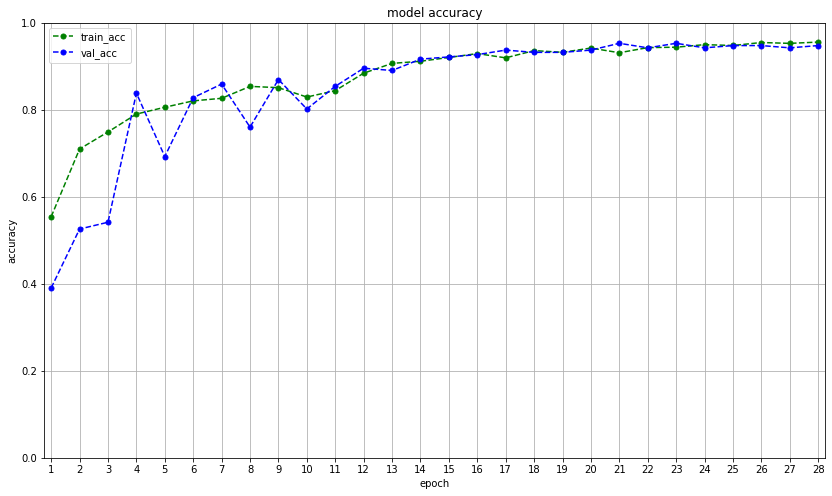

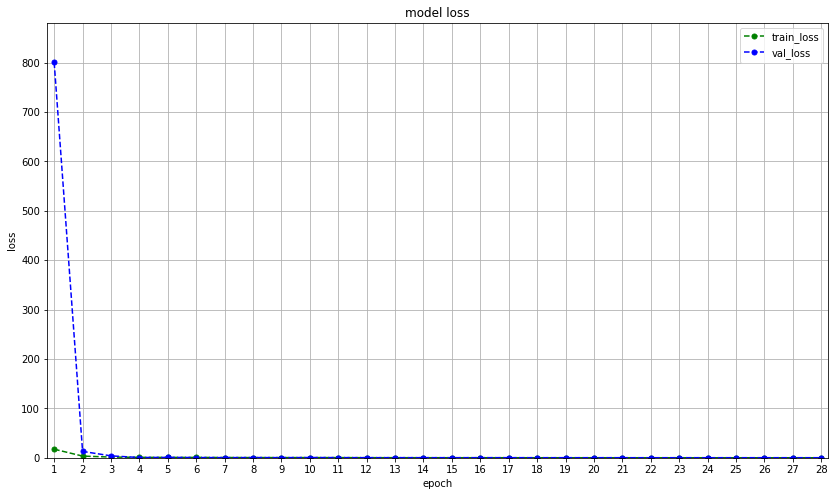

In [36]:
if history is not None:
    plot_epochs(
    history=history,
    filepath=f"{MODELS_PATH}{MODEL_NAME}",
    lr_x_offset=0.25,
    lr_y_offset=0.02,
    scale=1000,
)

In [37]:
cm = confusion_matrix(
    y_pred=y_pred,
    y_true=y_true,
    labels=CLASSES,
    save=True,
    path=MODELS_PATH,
    file_name=MODEL_NAME,
)

In [38]:
cm.imbalance

False

In [39]:
# print four lines. Justify text after colon
print(
    f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}\n"
    f"{cm.Overall_ACC*100:<10.2f} {cm.PPV_Macro:<10.2f}"
    f"{cm.TPR_Macro:<10.2f} {cm.F1_Macro:<10.2f}"
)

Accuracy   Precision  Recall     F1 Score  
98.33      0.98      0.98       0.98      


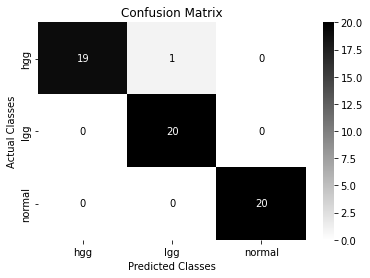

In [40]:
cm.plot(plot_lib = "seaborn", number_label=True)

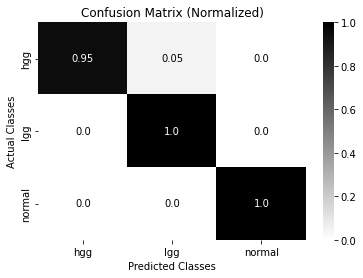

In [41]:
cm.plot(plot_lib = "seaborn", number_label=True, normalized=True)

In [42]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))


Accuracy: 0.98

Micro Precision: 0.98
Micro Recall: 0.98
Micro F1-score: 0.98

Macro Precision: 0.98
Macro Recall: 0.98
Macro F1-score: 0.98

Weighted Precision: 0.98
Weighted Recall: 0.98
Weighted F1-score: 0.98

Classification Report

              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        20
         lgg       0.95      1.00      0.98        20
         hgg       1.00      0.95      0.97        20

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60

